<a href="https://colab.research.google.com/github/WilliamPoe/CSCI-290/blob/main/notebooks/k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FixedLocator, FixedFormatter

# Datasets

In [2]:
df_penguin = pd.read_csv('https://github.com/WilliamPoe/CSCI-290/raw/refs/heads/main/Data/penguins.csv') # Penguins dataset
df_iris = pd.read_csv('https://github.com/WilliamPoe/CSCI-290/raw/refs/heads/main/Data/Iris.csv') # Iris dataset
df = pd.read_csv('https://github.com/mbrudd/csci290/raw/refs/heads/main/data/mystery.csv') # Mystery dataset

numeric_df = df.select_dtypes(include=[np.number])
numeric_df_iris = df_iris.select_dtypes(include=[np.number])

numeric_df_penguin = df_penguin.select_dtypes(include=[np.number])

#numeric_df = numeric_df.drop(columns='year')
numeric_df_iris = numeric_df_iris.drop(columns='Id')
numeric_df_penguin = numeric_df_penguin.drop(columns='year')
numeric_df_penguin = numeric_df_penguin.dropna()
numeric_df = numeric_df.dropna()
numeric_df_iris = numeric_df_iris.dropna()

# K Means Algorithim

In [3]:
class KMeans_clustering:

    def __init__(self, k=3, method = 'random', plot = False, max_iterations=100):
      self.k = k
      self.method = method
      self.plot = plot
      self.max_iterations = max_iterations

      if not self.plot:
        print('Plotting Disabled!')
      else:
        print('Plotting Enabled!')

    def euclidean_distance(self, point1, point2): # Calculate the euclidean distance
      return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

    def inertia_calc(self, data): # Calculate Inertia
      inertia = 0

      for cluster in range(self.k):
        for point in self.clusters[cluster]:
            inertia += np.sum((data.iloc[point] - self.centroids.iloc[cluster])**2)
      return inertia

    def silhouette_coefficients_calc(self, data): # Calculates the silhouette coefficients
      silhouette_scores = []
      print('In calc function')

      for idx in range(data.shape[0]):
        current_label = self.labels[idx]
        current_cluster = self.clusters[current_label]

        if len(current_cluster) > 1:
          cohesion = np.mean([self.euclidean_distance(data.iloc[idx], data.iloc[point]) for point in current_cluster if point != idx])
        else:
          cohesion = 0

        seperation = float('inf')
        for cluster_idx, other_cluster in enumerate(self.clusters):
          if cluster_idx != current_label:
            seperation_distance = np.mean([self.euclidean_distance(data.iloc[idx], data.iloc[point]) for point in other_cluster])
            seperation = min(seperation, seperation_distance)

        silhouette = (seperation - cohesion) / max(cohesion, seperation) if max(cohesion, seperation) > 0 else 0
        silhouette_scores.append(silhouette)

      return np.mean(silhouette_scores), silhouette_scores

    def inertia(self, data, k_values): # Calculate the Inertia for k values and plots
      inertia_vals = []

      for k in k_values:
        self.k = k
        self.fit(data)

        inertia = self.inertia_calc(data)
        inertia_vals.append(inertia)

        print(f'Inertia for k={k}: {inertia}')

      plt.figure(figsize=(8, 3.5))
      plt.plot(k_values, inertia_vals, "bo-")
      plt.xlabel("$k$")
      plt.ylabel("Inertia")
      plt.grid()
      plt.show()

    def silhouette_coefficient(self, data, k_values): # Calculate the silhouette coefficient for k values and plots
      silhouette_scores = []
      all_silhouette_values = []

      for k in k_values:
        self.k = k
        self.fit(data)

        avg_silhouette, point_silhouette_scores = self.silhouette_coefficients_calc(data)
        silhouette_scores.append(avg_silhouette)
        all_silhouette_values.append(point_silhouette_scores)

        print(f'Silhouette coefficient for k={k}: {avg_silhouette}')

      num_rows = int(np.ceil(len(k_values) / 2))
      num_cols = min(2, len(k_values))

      plt.figure(figsize=(11, 9))
      for idx, k in enumerate(k_values):
        plt.subplot(num_rows, num_cols, idx+1)

        point_silhouettes = np.array(all_silhouette_values[idx])
        y_pred = np.array(self.labels)

        padding = len(data) // 30
        pos = padding
        ticks = []
        for cluster_idx in range(k):
          coeffs = point_silhouettes[y_pred == cluster_idx]
          coeffs.sort()

          color = plt.cm.Spectral(cluster_idx / k)
          plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
          ticks.append(pos + len(coeffs) // 2)
          pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

        if k in (3, 5):
          plt.ylabel("Cluster")

        if k in (5, 6):
          plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
          plt.xlabel("Silhouette Coefficient")

        else:
          plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[idx], color="red", linestyle="--")
        plt.title(f"$k={k}$")

      plt.suptitle("Silhouette Analysis", fontsize=16)
      plt.show()

    def ran_centroids(self, data): # Picks random centroids from dataset
      ran_centroids = data.sample(self.k).index
      return data.loc[ran_centroids]

    def centroid_selection(self, data): # Selects centroids far apart from each other
      centroids = pd.DataFrame(columns=data.columns, index=range(self.k))
      centroids.iloc[0] = data.sample(1).index
      for i in range(self.k):
        distances = []
        for idx, point in data.iterrows():
          near_distances = min([self.euclidean_distance(point, centroid) for _, centroid in centroids.iterrows()])
          distances.append(near_distances)
        centroids.iloc[i] = data.iloc[np.argmax(distances)]
      return centroids

    def calc_centroids(self, clusters, data): # Calculate the new centroids from the clusters
      centroids = pd.DataFrame(columns=data.columns, index=range(self.k))
      for i, cluster in enumerate(clusters):
        centroids.iloc[i] = np.mean(data.iloc[[idx for idx in cluster]], axis=0)
      return centroids

    def pick_centroids(self, data): # Picks centroids based on user input
      centroids = pd.DataFrame(columns=data.columns, index=range(self.k)) # Could add an condition to check if a number has already been entered
      for i in range(self.k):
        idx = int(input(f'Pick an index for a centroid between {0, self.n_samples-1}: '))
        centroids.iloc[0] = data.iloc[idx]
      return centroids

    def distances(self, point, centroids): # Calculate the distance between the data and the centroids using euclidean distances function
      distances = [self.euclidean_distance(point, centroid) for _, centroid in centroids.iterrows()]
      return np.argmin(distances)

    def clustering(self, data, centroids): # Clusters the data together based off of the calculated distances
      clusters = [[] for _ in range(self.k)]
      labels = np.empty(self.n_samples, dtype=int)
      for idx in range(data.shape[0]):
        point = data.iloc[idx]
        cluster_index = self.distances(point, centroids)
        clusters[cluster_index].append(idx)
        labels[idx] = cluster_index
      return clusters, labels

    def accuracy(self, true_labels): # Calculates the accuracy
      majority_labels = {}
      for cluster in range(self.k):
        cluster_points = [idx for idx, label in enumerate(self.labels) if label == cluster]
        t_cluster_labels = [true_labels[idx] for idx in cluster_points]

        majority_label = max(set(t_cluster_labels), key=t_cluster_labels.count)
        majority_labels[cluster] = majority_label

      correct_predictions = sum(majority_labels[label] == true_labels[idx] for idx, label in enumerate(self.labels))
      accuracy = correct_predictions / self.n_samples
      return accuracy

    def fit(self, data): # Fits the data
      self.n_samples, self.n_features = data.shape[0], data.shape[1]
      print('The number of samples is:',self.n_samples)
      print('The number of features is:',self.n_features,'\n')

      if self.method.lower() == 'random':
        self.centroids = self.ran_centroids(data)
      elif self.method.lower() == 'calculated':
        self.centroids = self.centroid_selection(data)
      elif self.method.lower() == 'choice':
        self.centroids = self.pick_centroids(data)
      else:
        print('Invalid method')
        return

      for iteration in range(self.max_iterations):
        self.clusters, self.labels = self.clustering(data, self.centroids)
        cur_centroids = self.calc_centroids(self.clusters, data)

        if self.plot:

          plt.figure(figsize=(5, 3))

          # Plots the data points with cluster colors
          sns.scatterplot( x = data.iloc[:, 0], y = data.iloc[:, 1], hue = self.labels, palette='viridis')

          # Plots the centroids with a different color
          sns.scatterplot( x = cur_centroids.iloc[:, 0], y = cur_centroids.iloc[:, 1], c = "black", marker="X", s = 100);

          plt.title(f'Cluster Visualization - Iteration {iteration}')
          plt.xlabel('Feature 1')
          plt.ylabel('Feature 2')

          plt.show()

        if self.centroids.equals(cur_centroids.set_index(self.centroids.index)):
          print('The centroids have converged')
          print('The number of iterations is:',iteration)
          break
        self.centroids = cur_centroids

# Centroid Calculation for `Penguin Dataset`

Plotting Enabled!
The number of samples is: 342
The number of features is: 4 



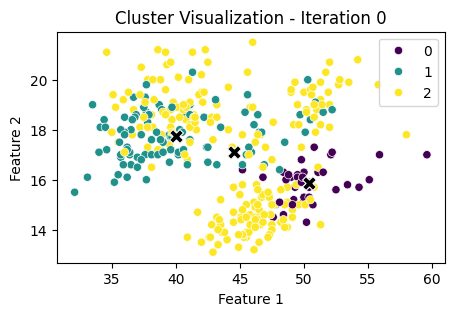

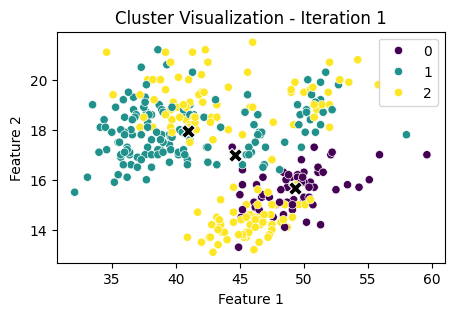

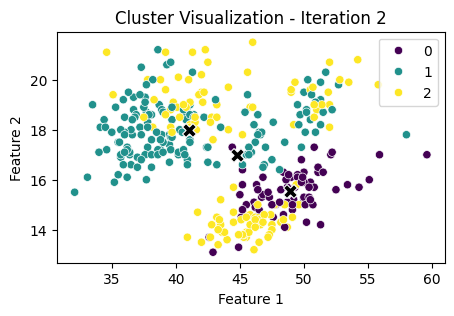

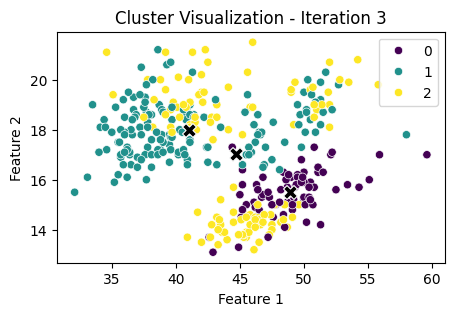

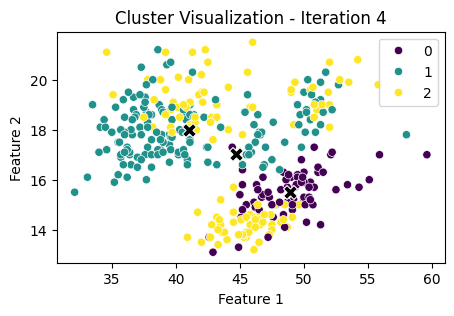

The centroids have converged
The number of iterations is: 4


In [4]:
model = KMeans_clustering(k=3, method='calculated', plot=True)
model.fit(numeric_df_penguin)
labels = model.labels
centroids = model.centroids

# Centroid Calculation for `Iris Dataset`



Plotting Enabled!
The number of samples is: 150
The number of features is: 4 



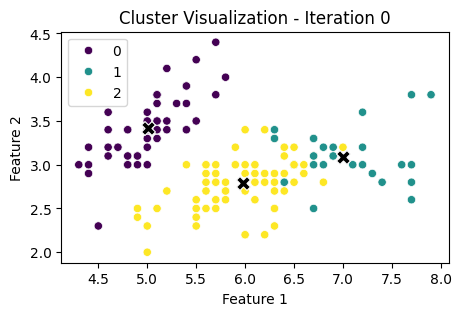

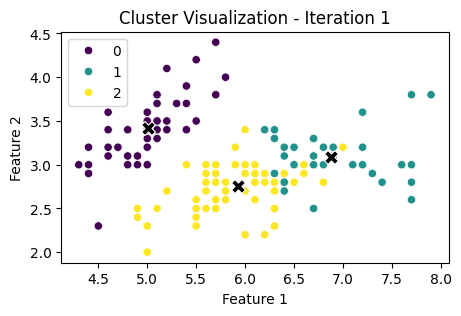

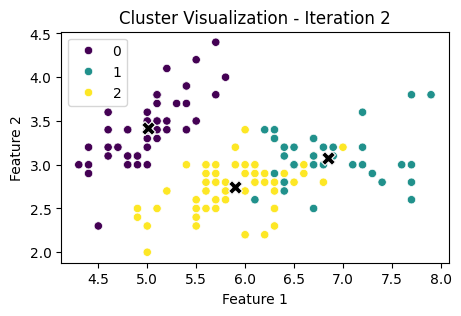

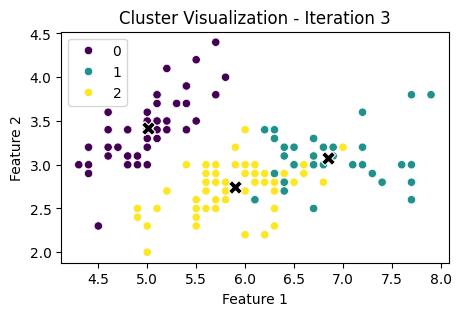

The centroids have converged
The number of iterations is: 3


In [ ]:
# centroid options (random, calculated, choice)
model = KMeans_clustering(k=3, method='calculated', plot=True)
model.fit(numeric_df_iris)
labels = model.labels
centroids = model.centroids


# Silhouette Coefficient for `Mystery Dataset`

Streaming output truncated to the last 5000 lines.
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385

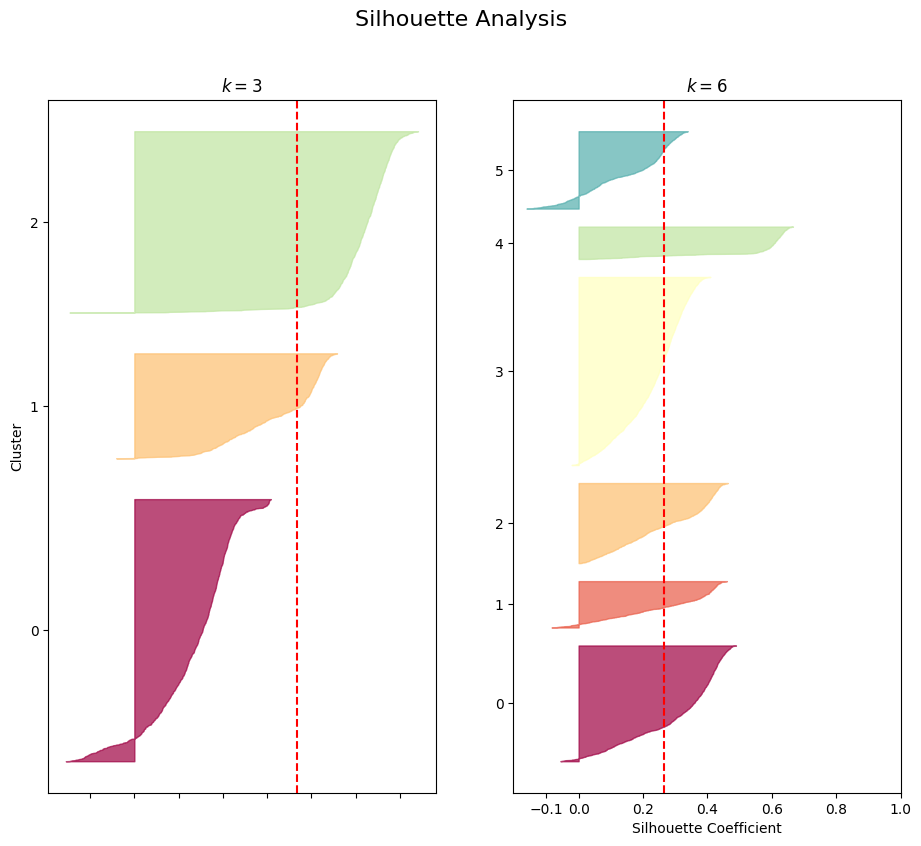

In [ ]:
sample_size = int(len(numeric_df) * 0.3)  # Take a 10% random sample
numeric_sample = numeric_df.sample(n=sample_size, random_state=42)

k_values = [3,6]
model = KMeans_clustering(k=3, method='calculated', plot=False)
model.silhouette_coefficient(numeric_df, k_values)


# Inertia for Mystery Dataset

Plotting Disabled!
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 1
Inertia for k=1: 3727.5241671398376
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 10
Inertia for k=2: 2465.7641259382003
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 10
Inertia for k=3: 2063.494717076791
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 24
Inertia for k=4: 1948.3002490077154
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 24
Inertia for k=5: 1634.6137797494553
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 23
Inertia for k=6: 1400.0506836618542
The number of samples i

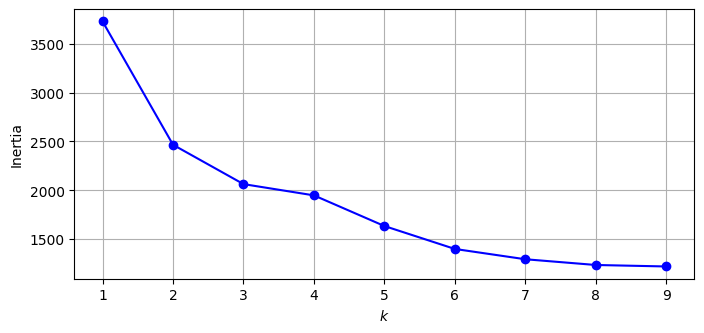

In [ ]:
inerta_k =range(1,10)
model = KMeans_clustering(k=3, method='calculated', plot=False)
model.inertia(numeric_df,inerta_k)

In [ ]:
k_values = [5]
model = KMeans_clustering(k=3, method='calculated', plot=False)
model.silhouette_coefficient(numeric_df, k_values)

Plotting Disabled!
The number of samples is: 7195
The number of features is: 22 

The centroids have converged
The number of iterations is: 24
In calc function


# Accuracy for Datasets

In [ ]:
#true_labels = df['species'].apply(lambda x: {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}[x]).values
true_labels = df_iris['Species'].apply(lambda x: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}[x]).values

model = KMeans_clustering(k=3, method='calculated', plot=False)
model.fit(numeric_df_iris)
labels = model.labels
centroids = model.centroids

accuracy = model.accuracy(true_labels)
print('Accuracy:', accuracy)

Plotting Disabled!
The number of samples is: 150
The number of features is: 4 

The centroids have converged
The number of iterations is: 3
Accuracy: 0.8933333333333333
